In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from preprocessing.encoding_pipeline import processing_pipe

# Importing and preprocessing clean data

In [3]:
clean_data = gpd.read_file("../raw_data/project_data_clean.shp")

In [4]:
X_clean = clean_data.drop(columns=['green_roof', 'geometry'])
y = clean_data['green_roof']
#geometry = 

In [5]:
X = processing_pipe(X_clean)

In [6]:
X.shape

(18015, 74)

# Model training, evaluations and export

In [38]:
model_params = {'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'init': None,
 'learning_rate': 0.09,
 'loss': 'exponential',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [39]:
model = GradientBoostingClassifier(**model_params).fit(X, y)

In [40]:
y_pred_proba = model.predict_proba(X)[:,1]

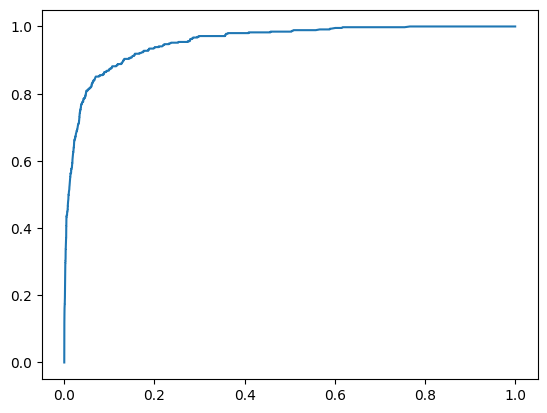

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
auc = metrics.roc_auc_score(y, y_pred)

plt.plot(fpr,tpr,label= str(auc));

In [42]:
# Choosing classification threshold to compensate for unbalanced data
metrics_data = pd.DataFrame({'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})

threshold = 0.024697

In [43]:
def custom_predict_proba(y_pred, threshold):
    """Function applies different threshold for final classification.
    For scores above the threshold classifiers returns 1.
    For scores under the threshold classifiers returns relative score w.r.t threshold.
    """
    predictions = []
    if y_pred.ndim == 1:
        for pred in y_pred:
            if pred >= threshold:
                predictions.append(1)
            else:
                predictions.append(round(pred/threshold,3))
    else:
        for pred in y_pred[:,1]:
            if pred >= threshold:
                predictions.append(1)
            else:
                predictions.append(round(pred/threshold,3))
    return predictions

In [44]:
# Computes scores w.r.t to threshold
y_pred_threshold =  custom_predict_proba(y_pred, threshold)

In [45]:
cm = metrics.confusion_matrix(y, y_pred>threshold)
tpr = cm[1][1]/(cm[1][1]+cm[1][0])
fpr = cm[0][1]/(cm[0][0]+cm[0][1])

print(cm)

print('tpr is:',tpr)
print('fpr is:',fpr)

tt = f"""This means that the model is capable of predicting {100 * tpr}% of the of the green roofs 
and { 100 * (1 - fpr)}% of the non-green roofs correctly.
"""
print(tt)

[[15698  1861]
 [   55   401]]
tpr is: 0.8793859649122807
fpr is: 0.10598553448374053
This means that the model is capable of predicting 87.93859649122807% of the of the green roofs 
and 89.40144655162595% of the non-green roofs correctly.



# Visualization